In [ ]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import numpy as np
import lxml
from IPython.display import Image 
from IPython.core.display import HTML
from IPython.display import display_html
import string
from geopy.geocoders import Nominatim 
import folium
import json
from pandas import json_normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
print("Libraries Imported...")

Libraries Imported...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## **Scraping area wise property buy rates data from www.99acres.com using BeutifulSoup**

In [ ]:
source=requests.get('https://www.99acres.com/property-rates-and-price-trends-in-mumbai').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
tab=str(soup.table)
#display_html(tab,raw=True)
df=pd.read_html(tab)
df=df[0]
df.head()

<title>Property Rates in Mumbai - Property Prices / Trends in Mumbai</title>


Locality Name  ...         Rental Rates
  Unnamed: 0_level_1  ...            3 Bedroom
0       Mumbai Thane  ...         Mumbai Thane
1        Anand Nagar  ...  Rs. 20,995 - 29,835
2             Balkum  ...  Rs. 27,898 - 30,324
3        Balkum Pada  ...                    -
4      Bhayandarpada  ...                    -

[5 rows x 7 columns]

In [ ]:
# removing unwanted columns from above dataframe and creating new dataframe
finaldf=pd.DataFrame(columns=['Locality','Rates'])
finaldf['Locality']=df['Locality Name']['Unnamed: 0_level_1']
finaldf['Rates']=df['Buy Rates']['Price Range (Rs. per sq. ft.)']
print("The number of Localities of Mumbai in original dataframe {}".format(finaldf.shape[0]))
# We will focus on locations from Andheri to Dahisar only
indx1=finaldf.index[finaldf.Locality.str.contains('Mumbai Andheri-Dahisar')]
indx2=finaldf.index[finaldf.Locality.str.contains('Mumbai South West')]
#print("Index1={} and Index2={}".format(indx1,indx2))
finaldf=finaldf.iloc[205:329,:]
print("The number of Localities of Mumbai from andheri to Dahisar in dataframe={}".format(finaldf.shape[0]))
finaldf=finaldf[finaldf.Rates.str.contains('\d')] #if Rates column contains other characters than digits then remove those rows
finaldf=finaldf.reset_index()
finaldf=finaldf[['Locality','Rates']]
print("The number of Localities after removing rows that don't contain rates(contains either '-' or area name)={}".format(finaldf.shape[0]))

if(~finaldf.isnull().values.any()):
   print("No null values are found")
finaldf.head()



The number of Localities of Mumbai in original dataframe 764
The number of Localities of Mumbai from andheri to Dahisar in dataframe=124
The number of Localities after removing rows that don't contain rates(contains either '-' or area name)=104
No null values are found


,Locality,Rates
0,4 Bunglows,"Rs. 20,272 - 25,288/sq. ft."
1,Aarey Milk Colony,"Rs. 7,565 - 8,840/sq. ft."
2,Alika Nagar,"Rs. 13,642 - 14,918/sq. ft."
3,Amboli,"Rs. 17,255 - 19,465/sq. ft."
4,Andheri (East),"Rs. 15,512 - 17,935/sq. ft."


In [ ]:
# convert price range(Rates) to avg. price
avgprice=[]
for i in range(len(finaldf)):
  prices=(finaldf.loc[i,'Rates']).replace("Rs.","")
  prices=prices.replace("/sq. ft.","")
  prices=prices.split("-")
  p1=float(prices[0].replace(",",""))
  p2=float(prices[1].replace(",",""))
  avgprice.append((p1+p2)/2)
  
avgrate=pd.Series(avgprice)

avgrate


0      22780.0
1       8202.5
2      14280.0
3      18360.0
4      16723.5
        ...   
99     17658.5
100    20209.0
101    21908.5
102    19401.0
103    17956.5
Length: 104, dtype: float64

### **We have finaldf dataframe which contains 104 records showing localities of Mumbai(from Andheri to Dahisar) and buy rates of properties /sq. ft. The next step is to find coordinates of each locality and add it to the dataframe. We will use geolocator library for the same.**

In [ ]:
lon=[]
lat=[]
for i in range(len(finaldf)):
  # Create address to pass in Nominatim
  if(i in [14,36]):
    continue;
  address=finaldf['Locality'][i]+',Mumbai,India'
  locator=Nominatim(user_agent="explorer")
  location=locator.geocode(address)
  
  try:
    latitude=location.latitude
    longitude=location.longitude
    lat.append(latitude)
    lon.append(longitude)
    print("Latitude and Longitude for {} , Mumbai,India are:{} and {}".format(finaldf['Locality'][i],latitude,longitude))
  except:
    lat.append(None)
    lon.append(None)
    print("Latitude and Longitude for {} , Mumbai , India are not available".format(finaldf['Locality'][i]))

  

Latitude and Longitude for 4 Bunglows , Mumbai,India are:19.0444711 and 72.91006
Latitude and Longitude for Aarey Milk Colony , Mumbai,India are:19.1561292 and 72.8707223
Latitude and Longitude for Alika Nagar , Mumbai , India are not available
Latitude and Longitude for Amboli , Mumbai,India are:19.1319915 and 72.8499596
Latitude and Longitude for Andheri (East) , Mumbai,India are:19.1158835 and 72.854202
Latitude and Longitude for Andheri (West) , Mumbai,India are:19.1172495 and 72.833968
Latitude and Longitude for Aram Nagar , Mumbai,India are:19.134031 and 72.8130524
Latitude and Longitude for Asha Nagar , Mumbai,India are:19.1691976 and 72.9446053
Latitude and Longitude for Ashok Nagar Kandivali , Mumbai,India are:19.204159 and 72.8516821
Latitude and Longitude for Azad Nagar , Mumbai,India are:19.1201112 and 72.8510836
Latitude and Longitude for Babhai , Mumbai,India are:19.2308309 and 72.8475648
Latitude and Longitude for Bangur Nagar , Mumbai,India are:19.1688142 and 72.8336777

In [ ]:
# Creating new dataframe with Latitude and Longitude of localities

lat=pd.Series(lat)
lon=pd.Series(lon)
finaldf1 = pd.DataFrame(columns=["Locality","Rates","Latitude", "Longitude"])
finaldf1['Locality']=finaldf['Locality']
finaldf1['Rates']=avgrate
finaldf1['Latitude']=lat 
finaldf1['Longitude']=lon
finaldf1.head()

,Locality,Rates,Latitude,Longitude
0,4 Bunglows,22780.0,19.044471,72.910060
1,Aarey Milk Colony,8202.5,19.156129,72.870722
2,Alika Nagar,14280.0,NaN,NaN
3,Amboli,18360.0,19.131992,72.849960
4,Andheri (East),16723.5,19.115883,72.854202


In [ ]:
#Dropping rows with NaN values

finaldf1.dropna(inplace=True)
finaldf1.head()

,Locality,Rates,Latitude,Longitude
0,4 Bunglows,22780.0,19.044471,72.910060
1,Aarey Milk Colony,8202.5,19.156129,72.870722
3,Amboli,18360.0,19.131992,72.849960
4,Andheri (East),16723.5,19.115883,72.854202
5,Andheri (West),22015.0,19.117249,72.833968


In [ ]:
# check for duplicates and remove it
print("Total number of unique localities={}".format(len(finaldf1['Locality'].unique())))
print("Total number of localities={}".format(finaldf1.shape[0]))
finaldf1.drop_duplicates(subset="Locality",keep='first',inplace=True)
print("After removing duplicates, number of neighborhood=",finaldf1.shape[0])


Total number of unique localities=92
Total number of localities=92
After removing duplicates, number of neighborhood= 92


## **Now we will start plotting. We have to create map of Mumbai localities(neighborhoods) so first let's find Mumbai coordinates. We will use folium to generate the map.**









In [ ]:
address='Mumbai,India'
geolocator=Nominatim(user_agent="explorer")
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print("Mumbai Latitude={} and Longitude={}".format(latitude,longitude))


Mumbai Latitude=19.0759899 and Longitude=72.8773928


In [ ]:
Mumbai_map=folium.Map(location=[latitude,longitude],zoom_start=10)
#add markers to map
for lt,lg,ng in zip(finaldf1['Latitude'],finaldf1['Longitude'],finaldf1['Locality']):
  lbl='{}'.format(ng)
  lbl=folium.Popup(lbl,parse_html=True)
  folium.CircleMarker(
        [lt, lg],
        radius=4,
        popup=lbl,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.85,
        parse_html=False).add_to(Mumbai_map)  
Mumbai_map
#print("Mumbai Latitude={} and Longitude={}".format(latitude,longitude))

## **Upto this point we have map of Mumbai neighborhoods along with buy rates of residential properties. This project focuses on finding restaurants in localities for the purpose of opening a new restaurant. We assume that the person who wants to open restaurant also looking for purchase of home in same or nearby locality as travelling in mumbai is one of the most difficult task. We will find venues in localities using FourSquare API.**

In [ ]:
venues=[]
CLIENT_ID = '0RXMTPLHYUU0DGM4P2M5GFV0YT5YOJ3VDUQDRHURZJGVFVWF' # your Foursquare ID
CLIENT_SECRET = 'DJQSIXTRQV3GI5OFDL4CYEZY4KWKBCJLQZVOTWXWPSPDHHHX' # your Foursquare Secret
ACCESS_TOKEN = 'LZVNQ0JFVM0FK4OOOBUFB00GISL0TEM3IG1ROQ0Z0IXDNXCJ' # your FourSquare Access Token
VERSION = '20180604'
limit = 50
radius=500

for name,lat,long in zip(finaldf1['Locality'],finaldf1['Latitude'], finaldf1['Longitude']):    
    
    # Create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        limit)    
    # Make the GET request to the API
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # Return only relevant information for each nearby venue
    venues.append([(
        name, 
        lat, 
        long, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

In [ ]:
# Creating new dataframe along with details of near by venues to all localities
nearby_venues = pd.DataFrame([item for venue in venues for item in venue])
nearby_venues.columns = ['Locality','Latitude','Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
nearby_venues.insert(1,'Rates',finaldf1['Rates'])
nearby_venues.head()

,Locality,Rates,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4 Bunglows,22780.0,19.044471,72.91006,n Bar & Grill,19.046523,72.908267,Lounge
1,4 Bunglows,8202.5,19.044471,72.91006,Shivaji Chowk,19.045973,72.909093,Plaza
2,4 Bunglows,NaN,19.044471,72.91006,Natraj Lawns,19.046134,72.908068,Garden
3,4 Bunglows,18360.0,19.044471,72.91006,The bar stock exchange,19.046546,72.908193,Lounge
4,4 Bunglows,16723.5,19.044471,72.91006,Subway,19.047055,72.907837,Health Food Store


In [ ]:
print(nearby_venues.shape)
nearby_venues.groupby(nearby_venues['Locality']).count()

(1043, 8)


,Rates,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Locality,,,,,,,
4 Bunglows,4,5,5,5,5,5,5
Aarey Milk Colony,2,2,2,2,2,2,2
Amboli,4,4,4,4,4,4,4
Andheri (East),9,10,10,10,10,10,10
Andheri (West),16,17,17,17,17,17,17
Aram Nagar,20,22,22,22,22,22,22
Asha Nagar,6,6,6,6,6,6,6
Ashok Nagar Kandivali,10,12,12,12,12,12,12
Azad Nagar,6,8,8,8,8,8,8


In [ ]:
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 156 uniques categories.


## **Next we will perform onehot encoding on nearby_venues dataframe. That will help to find average occurrences of the venues by locality**

In [ ]:
# Converting the categorical variables into indicator variables
mumbai_onehot = pd.get_dummies(nearby_venues['Venue Category'], prefix="", prefix_sep="")
# Adding the locality column
mumbai_onehot['Locality'] = nearby_venues['Locality']
# Fixing the columns in the dataframe
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]
mumbai_onehot.head()

,Locality,ATM,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Bengali Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Café,Camera Store,Campground,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,...,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Residential Building (Apartment / Condo),Resort,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Track,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Shop,Women's Store,Yoga Studio
0,4 Bunglows,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4 Bunglows,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4 Bunglows,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4 Bunglows,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4 Bunglows,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mumbai_grouped = mumbai_onehot.groupby(["Locality"]).mean().reset_index()
mumbai_grouped

,Locality,ATM,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Bengali Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Café,Camera Store,Campground,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,...,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Residential Building (Apartment / Condo),Resort,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Track,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Shop,Women's Store,Yoga Studio
0,4 Bunglows,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Aarey Milk Colony,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Amboli,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Andheri (East),0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.1,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Andheri (West),0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000

In [ ]:
# Now we will find restaurants in different localities and create a new dataframe
mumbai_restaurants = mumbai_grouped[["Locality","Restaurant"]]
# Find localities where restaurants are above some limit
mumbai_restaurants[mumbai_restaurants['Restaurant']>0.001].head()

,Locality,Restaurant
5,Aram Nagar,0.090909
6,Asha Nagar,0.166667
14,Borivali (West),0.117647
16,Chikuwadi,0.037037
17,Chincholi Bunder,0.045455


## Next we will perform KMeans clustering to find clusters of localities based on number of restaurants. We will analyse these clusters along with property buy rates.**

In [ ]:
clustering_mumbai=mumbai_restaurants.drop(['Locality'],1)

## **We use the KMeans method for clustering. We first employ the Elbow method to visualize and find the ideal number of clusters.**

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c9b5e0a90>,
                 k=None, metric=None, model=None, timings=True)

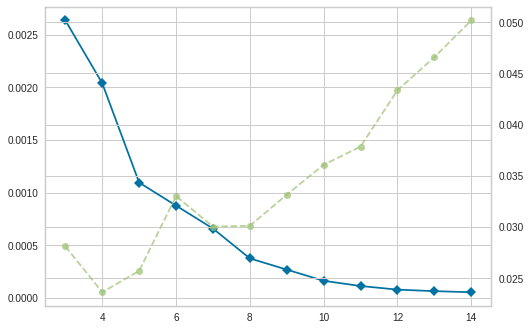

In [ ]:
# Using elbow method to find number of clusters
model = KMeans()
visualize = KElbowVisualizer(model, k=(3,15)) # Check for optimal clusters between 3-15

visualize.fit(clustering_mumbai)        # Fit the data 
#visualize.show()


In [ ]:
# Number of cluster=5
kclusters = 5
# Fitting data to KMeans algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_mumbai)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 3, 1, 0, 0, 0], dtype=int32)

In [ ]:
# Dataframe with cluster labels
mumbai_merged = mumbai_restaurants.copy()
mumbai_merged["Cluster Labels"] = kmeans.labels_
mumbai_merged.head()

,Locality,Restaurant,Cluster Labels
0,4 Bunglows,0.0,0
1,Aarey Milk Colony,0.0,0
2,Amboli,0.0,0
3,Andheri (East),0.0,0
4,Andheri (West),0.0,0


In [ ]:
restaurantdf=pd.merge(mumbai_merged,finaldf1[['Locality','Rates','Latitude','Longitude']],on='Locality')
restaurantdf.head()

,Locality,Restaurant,Cluster Labels,Rates,Latitude,Longitude
0,4 Bunglows,0.0,0,22780.0,19.044471,72.910060
1,Aarey Milk Colony,0.0,0,8202.5,19.156129,72.870722
2,Amboli,0.0,0,18360.0,19.131992,72.849960
3,Andheri (East),0.0,0,16723.5,19.115883,72.854202
4,Andheri (West),0.0,0,22015.0,19.117249,72.833968


## **We will now generate map for displaying clusters along with localities**

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
colorbar = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
markers_colors = []
for lat, lon, poi, cluster,rates  in zip(restaurantdf['Latitude'], restaurantdf['Longitude'], restaurantdf['Locality'], restaurantdf['Cluster Labels'], restaurantdf['Rates']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        tooltip = str(poi)+', '+str(rates),
        color=colorbar[cluster],
        fill=True,
        fill_color=colorbar[cluster],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

## Analysing clusters for number of restaurants and buy rates of properties.

In [ ]:
 #pd.set_option('display.max_rows', restaurantdf.shape[0]+1)

# Cluster 0
restaurantdf[restaurantdf['Cluster Labels'] == 0].head()

,Locality,Restaurant,Cluster Labels,Rates,Latitude,Longitude
0,4 Bunglows,0.0,0,22780.0,19.044471,72.910060
1,Aarey Milk Colony,0.0,0,8202.5,19.156129,72.870722
2,Amboli,0.0,0,18360.0,19.131992,72.849960
3,Andheri (East),0.0,0,16723.5,19.115883,72.854202
4,Andheri (West),0.0,0,22015.0,19.117249,72.833968


In [ ]:
# Cluster 1
restaurantdf[restaurantdf['Cluster Labels'] == 1]

,Locality,Restaurant,Cluster Labels,Rates,Latitude,Longitude
6,Asha Nagar,0.166667,1,16405.0,19.169198,72.944605
19,Dahanukar Wadi,0.200000,1,15682.5,19.249450,72.859621
25,Devipada,0.166667,1,15618.5,19.174020,72.869522
29,Film City Road,0.142857,1,14535.0,19.173853,72.867093
35,Huzefa Nagar,0.166667,1,16723.5,19.202316,72.842236
86,Vaishali Nagar,0.200000,1,12198.0,19.228911,72.844639


In [ ]:
# Cluster 2
restaurantdf[restaurantdf['Cluster Labels'] == 2]

,Locality,Restaurant,Cluster Labels,Rates,Latitude,Longitude
18,DN Nagar,0.285714,2,23268.5,19.241026,72.844074
20,Dahisar,0.250000,2,12133.5,19.248693,72.864059
66,Orlem,0.250000,2,16065.0,19.136918,72.869128


In [ ]:
# Cluster 3
restaurantdf[restaurantdf['Cluster Labels'] == 3]

,Locality,Restaurant,Cluster Labels,Rates,Latitude,Longitude
5,Aram Nagar,0.090909,3,24310.0,19.134031,72.813052
14,Borivali (West),0.117647,3,16872.0,19.115287,72.861808
32,Gorai 2,0.083333,3,13302.5,19.163328,72.841200
37,Irani Wadi,0.083333,3,15427.0,19.160730,72.847531
39,JVLR,0.117647,3,18338.5,19.210381,72.864084
52,Lokhandwala Andheri West,0.111111,3,23056.5,19.130609,72.873816
64,Motilal Nagar II,0.100000,3,14811.5,19.194482,72.838966
89,Veera Desai Road,0.125000,3,20209.0,19.139402,72.807916


In [ ]:
# Cluster 4
restaurantdf[restaurantdf['Cluster Labels'] == 4]

,Locality,Restaurant,Cluster Labels,Rates,Latitude,Longitude
16,Chikuwadi,0.037037,4,16299.0,19.179251,72.838415
17,Chincholi Bunder,0.045455,4,15236.0,19.098705,72.851599
22,Dahisar (West),0.055556,4,14683.5,19.220890,72.853254
33,Goregaon (East),0.058824,4,16468.5,19.052190,72.891294
34,Hemu Colony,0.047619,4,15257.5,19.244625,72.847925
65,Nensey Colony,0.026316,4,14896.5,19.150244,72.834229
68,Rajendra Nagar,0.066667,4,17191.0,19.084161,72.910591
